In [1]:
import numpy as np                               
import pandas as pd                        
import matplotlib.pyplot as plt                             
from PIL import Image                           
import os                                        
from sklearn.model_selection import train_test_split
#from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Conv2D
#! pip install imgaug
import imgaug.augmenters as iaa

In [2]:
print(tf.__version__)

2.4.1


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Read images from files, resize, convert to grey(optional)

In [4]:
data = []
labels = []

wd = os.getcwd()

In [5]:
if not os.path.exists(os.path.join(wd,'new_images')):
    
    path1 = os.path.join(wd,'./data')
    images1 = os.listdir(path1)

    for i in images1:
        path = os.path.join(wd,'./data', str(i))
        images = os.listdir(path)
        for j in images :
            try:
            #open the original image
                image = Image.open(path + '\\'+ j)
            
            #resizing all images to the same size dimension
                image = image.resize((56, 56))
            
            #create new directory if it doesnt already exist for the new converted images
                if not os.path.exists(os.path.join(wd,'new_images', str(i))):  
                    os.makedirs(os.path.join(wd,'new_images', str(i)))
                    os.chdir(os.path.join(wd,'new_images', str(i)))
                
            #save and open the new png images    
                image.save(os.path.splitext(j)[0]+'.png')
                image = Image.open(os.path.splitext(j)[0]+'.png')
                image = np.array(image)
            
                data.append(image)
                labels.append(i)
            except:
             #not really an error just bcz of the csv files, take this as a loading notification or we can just remove it 
                print('cant read ', str(j), 'loading images...')

else:
    path1 = os.path.join(wd,'new_images')
    images1 = os.listdir(path1)

    for i in images1:
        path = os.path.join(wd,'new_images', str(i))
        images = os.listdir(path)
        for j in images :
            #open the original image
            image = Image.open(path + '\\'+ j)
            image = np.array(image)
            data.append(image)
            labels.append(i)

In [6]:
data = data[:-1]
labels = labels[:-1]

In [7]:
print('number of images',len(data),'shape',len(data[0]),len(data[0][0]), len(data[0][0][0]))

number of images 33321 shape 56 56 3


# Convert to Grey images (optional)

In [8]:
data_grey = []

for x in range(len(data)):
    data_grey.append( np.mean(data[x], axis=2) )

# Show some images

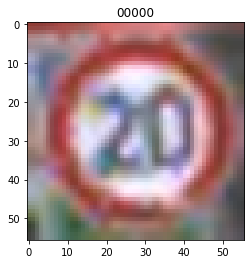

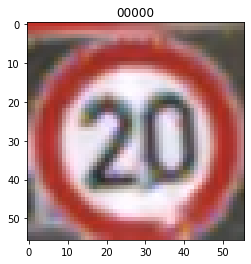

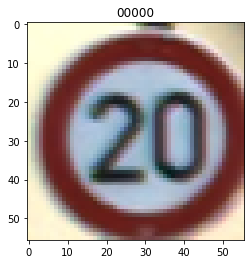

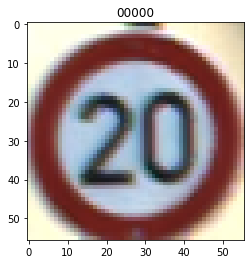

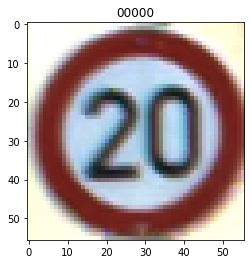

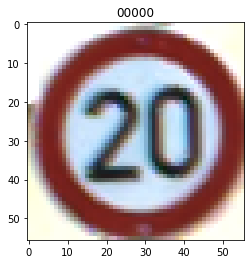

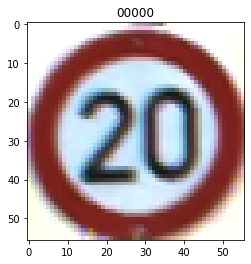

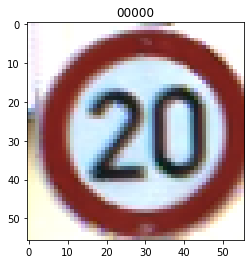

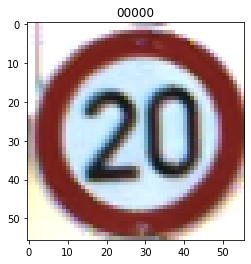

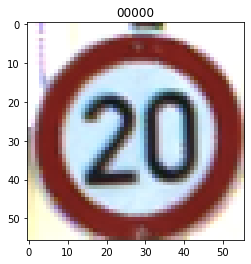

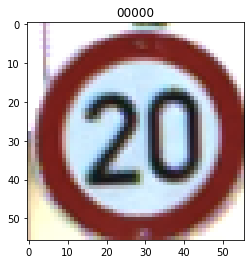

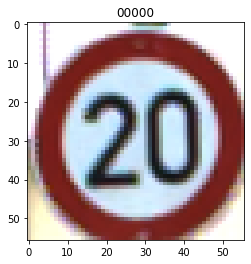

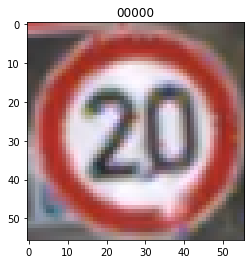

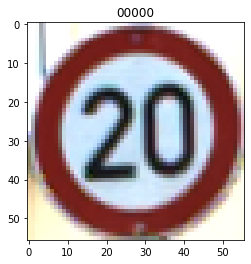

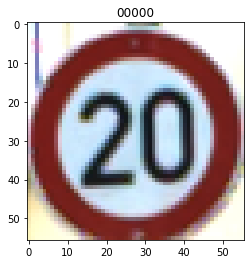

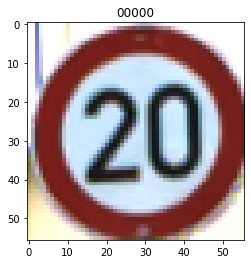

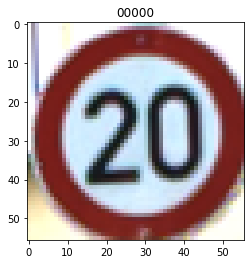

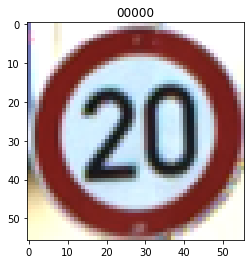

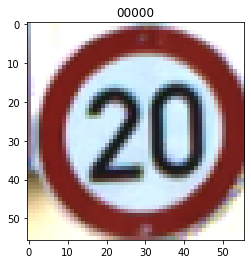

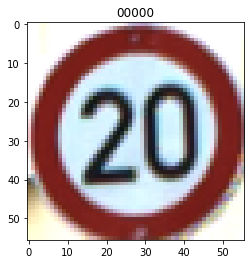

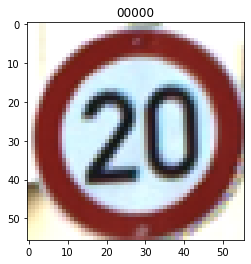

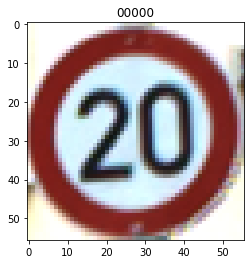

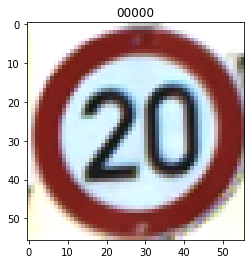

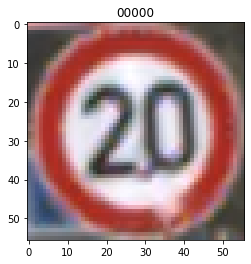

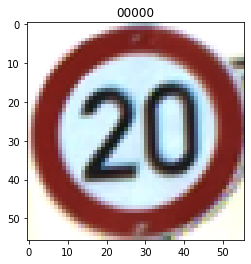

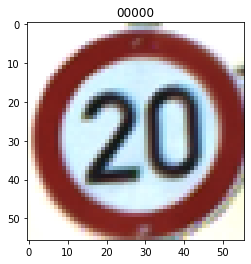

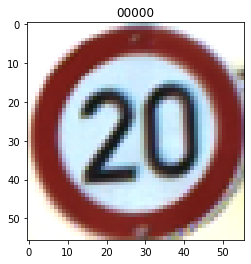

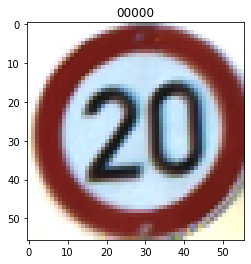

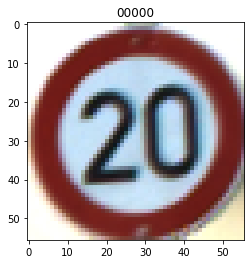

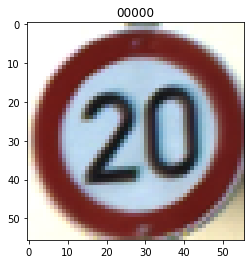

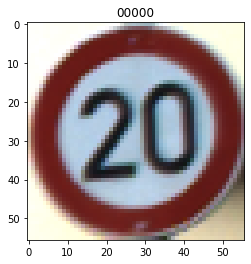

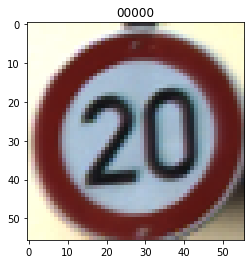

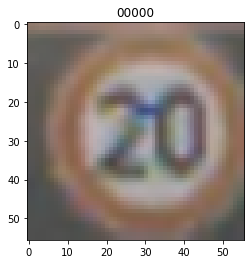

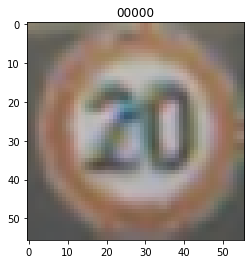

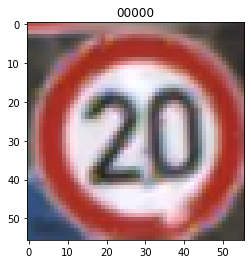

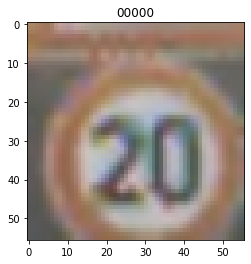

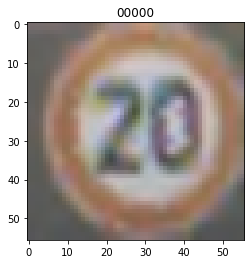

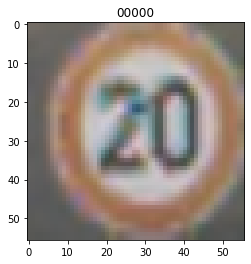

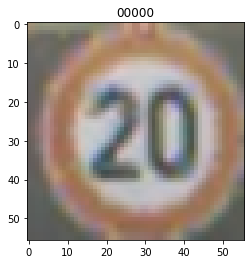

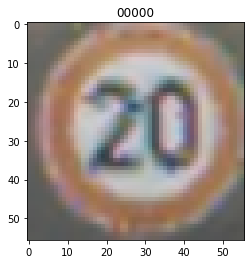

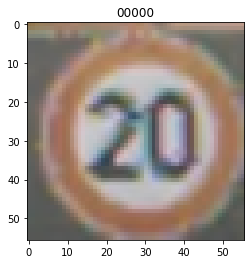

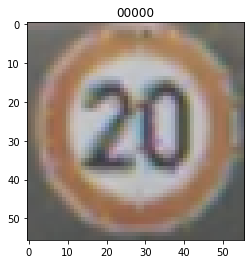

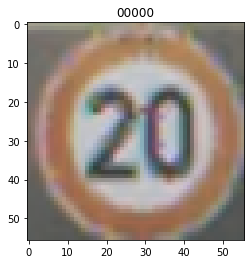

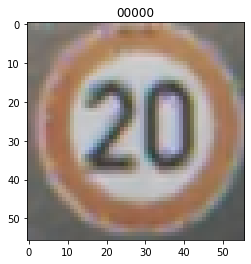

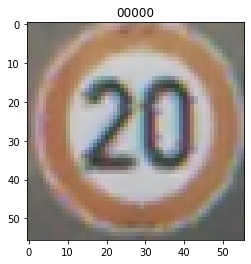

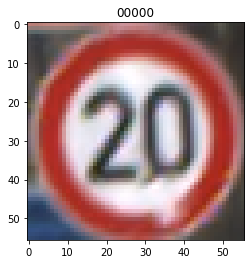

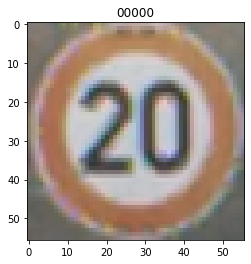

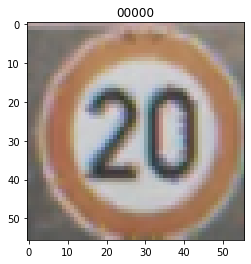

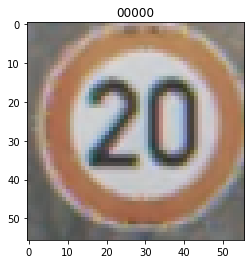

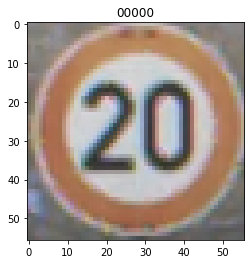

In [9]:
for k in range(0,50):
    #to show normal images
    image = data[k]
    plt.imshow(image)
    
    #to show grey images
    #image = data_grey[k]
    #plt.imshow(image, cmap=plt.get_cmap("gray"))
    
    plt.title(labels[k])
    plt.show()

# Split train_test

In [9]:
#replace data with data_grey for grey images
#replace data with data_grey for grey images
x_train, x_test, y_train, y_test = train_test_split(data_grey, labels, test_size=0.2, random_state=68)
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size=0.125)
x_val = np.array(x_val)

In [10]:
#lets see the classes with less than 1000 images
#we should perform this in the data exploration with some visuals

for x in set(y_train):
    if y_train.count(x)<1000:
        print(x, y_train.count(x))    

00040 242
00020 205
00008 834
00041 124
00019 153
00009 858
00017 516
00024 180
00014 503
00027 161
00036 219
00031 522
00037 133
00015 354
00039 187
00006 218
00003 776
00018 740
00025 967
00035 720
00034 232
00011 810
00032 117
00028 366
00007 811
00021 218
00016 259
00026 360
00000 126
00030 284
00023 337
00022 247
00042 128
00029 177
00033 404


# Image augmentation

In [12]:
def augment_imgs(imgs, p):
    
    augs =  iaa.SomeOf((2, 4),
          [
              iaa.Crop(px=(0, 4)), # crop images from each side by 0 to 4px (randomly chosen)
              iaa.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}),
              iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}),
              iaa.Affine(rotate=(-45, 45)), # rotate by -45 to +45 degrees)
              iaa.Affine(shear=(-10, 10)) # shear by -10 to +10 degrees
          ])
    
    seq = iaa.Sequential([iaa.Sometimes(p, augs)])
    
    return seq.augment_image(imgs)

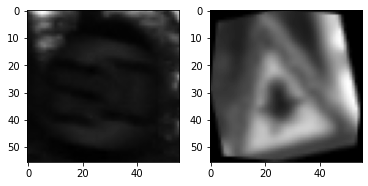

In [13]:
ai = augment_imgs(x_train[0], 1)

plt.subplot(1, 2, 1)
plt.imshow(x_train[200], cmap=plt.get_cmap("gray"))
#plt.imshow(x_train[0])

plt.subplot(1, 2, 2)
plt.imshow(ai, cmap=plt.get_cmap("gray"))
#plt.imshow(ai)

In [14]:
#doing augmentation for classes with less than 1000 images
#adding them to the train data
for x in set(y_train):
    while y_train.count(x)<1000:
        for i in range(len(y_train)):
            if y_train[i]==x:
                x_train.append(augment_imgs(x_train[i], 1))
                y_train.append(y_train[i])
            

In [15]:
#see some of the augmented images we added
for k in range(5000, 5000):
    
    image = x_train[k]
    plt.imshow(image)
    #plt.imshow(image, cmap=plt.get_cmap("gray"))
    plt.title(y_train[k])
    plt.show()

In [11]:
x_train = np.array(x_train)
x_test = np.array(x_test)
x_val = np.array(x_val)
y_test = np.array(y_test)
y_train = np.array(y_train)
y_val = np.array(y_val)

#NORMALISATION
x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
# print(y_test)

(23324, 56, 56) (6665, 56, 56) (23324,) (6665,)


# Remove Noise Autoenconder for RGB images

In [17]:
# encoder = keras.models.Sequential([
#   keras.layers.Conv2D(16, kernel_size=3, padding="same", activation="selu", input_shape=[56, 56, 3]),
#   keras.layers.MaxPool2D(pool_size=2),
#   keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="selu"),
#   keras.layers.MaxPool2D(pool_size=2),
#   keras.layers.Flatten(),
#   keras.layers.Dense(30, activation="selu")
# ])
# decoder = keras.models.Sequential([
#   keras.layers.Dense(64*14*14, input_shape=[30], activation="selu"),
#   keras.layers.Reshape([14, 14, 64]),
#   keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="same", activation="selu"),
#   keras.layers.Conv2DTranspose(3, kernel_size=3, strides=2, padding="same", activation="sigmoid"),
#   keras.layers.Reshape([56, 56, 3])
# ])
# ae = keras.models.Sequential([encoder, decoder])
# ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.5), metrics = ["accuracy"])
# history=ae.fit(x_train, x_train, epochs=20, validation_split=0.1)

# # Visualise results
# def plot_image(image):
#     plt.imshow(image, cmap="binary")
#     plt.axis("off")

In [18]:
# n_images = 20
# reconstructions = ae.predict(x_test[:n_images])
# fig=plt.figure(figsize=(n_images*1.5, 3))

# for idx in range(n_images):
#     plt.subplot(2, n_images, 1+idx)
#     plot_image(x_test[idx])
#     plt.subplot(2, n_images, 1+n_images+idx)
#     plot_image(reconstructions[idx])

# Remove Noise Autoenconder for Grey images

In [19]:
# encoder = keras.models.Sequential([
#   keras.layers.Reshape([56, 56, 1], input_shape=[56, 56]),
#   keras.layers.Conv2D(16, kernel_size=3, padding="same", activation="selu"),
#   keras.layers.MaxPool2D(pool_size=2),
#   keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="selu"),
#   keras.layers.MaxPool2D(pool_size=2),
#   keras.layers.Flatten(),
#   keras.layers.Dense(30, activation="selu")
# ])
# decoder = keras.models.Sequential([
#   keras.layers.Dense(64*14*14, input_shape=[30], activation="selu"),
#   keras.layers.Reshape([14, 14, 64]),
#   keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="same", activation="selu"),
#   keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="same", activation="sigmoid"),
#   keras.layers.Reshape([56, 56])
# ])
# ae = keras.models.Sequential([encoder, decoder])
# ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.5), metrics = ["accuracy"])
# history=ae.fit(x_train, x_train, epochs=5, validation_split=0.1)

# # Visualise results
# def plot_image(image):
#     plt.imshow(image, cmap="binary")
#     plt.axis("off")


In [20]:
# n_images = 20
# reconstructions = ae.predict(x_test[:n_images])
# fig=plt.figure(figsize=(n_images*1.5, 3))

# for idx in range(n_images):
#     plt.subplot(2, n_images, 1+idx)
#     plot_image(x_test[idx])
#     plt.subplot(2, n_images, 1+n_images+idx)
#     plot_image(reconstructions[idx])


***
# Building models  
# Create model with Keras 

In [12]:
# Reimport package
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')


# get train test
# print(x_train[0].shape, x_test.shape, y_train.shape, y_test.shape)
# print(x_train[0].shape)
#Initialize the relevant variables
x_train=x_train.reshape((x_train.shape[0],x_train.shape[1],x_train.shape[2],1))
x_val=x_val.reshape((x_val.shape[0],x_val.shape[1],x_val.shape[2],1))
x_test=x_test.reshape((x_test.shape[0],x_test.shape[1],x_test.shape[2],1))                        
print('x_train:',x_train.shape)
print('x_test:', x_test.shape)
print('y_train:',y_train.shape)
print('y_test:',y_test.shape)
img_height,img_width,channels=x_train[0].shape
class_num=len(np.unique(y_train))

# One hot encoding the labels
y_train_hot = keras.utils.to_categorical(y_train, class_num)
y_val_hot = keras.utils.to_categorical(y_val, class_num)
y_test_hot = keras.utils.to_categorical(y_test, class_num)
y_test_hot

x_train: (23324, 56, 56, 1)
x_test: (6665, 56, 56, 1)
y_train: (23324,)
y_test: (6665,)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# Making the model


In [22]:
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(img_height,img_width,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(class_num, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 54, 54, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 52, 52, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 26, 26, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 128)       0

# Set the hyperparameters

In [23]:
lr = 0.001
epochs = 30

opt = Adam(lr=lr, decay=lr / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Set the callbacks

In [24]:
# define learning rate sheduler
def schedule(epoch):
    lr = 0.001/(epoch+1)

    return lr

lrs = tf.keras.callbacks.LearningRateScheduler(
    schedule=schedule,
    verbose=1)

# checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint
filepath = "./grey-big.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True,
mode='max')
callbacks_list = [lrs,checkpoint]

# Augmenting the data and training the model

In [25]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")
history = model.fit(aug.flow(x_train, y_train_hot, batch_size=256), epochs=epochs, validation_data=(x_val, y_val_hot),callbacks=callbacks_list)

Epoch 1/30

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
242/242 [==============================] - 23s 82ms/step - loss: 2.5960 - accuracy: 0.3923 - val_loss: 4.8542 - val_accuracy: 0.0093

Epoch 00001: val_accuracy improved from -inf to 0.00930, saving model to .\grey-big.h5
Epoch 2/30

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0005.
242/242 [==============================] - 17s 69ms/step - loss: 0.4671 - accuracy: 0.8698 - val_loss: 4.6496 - val_accuracy: 0.1188

Epoch 00002: val_accuracy improved from 0.00930 to 0.11885, saving model to .\grey-big.h5
Epoch 3/30

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0003333333333333333.
242/242 [==============================] - 17s 68ms/step - loss: 0.2826 - accuracy: 0.9230 - val_loss: 0.0849 - val_accuracy: 0.9853

Epoch 00003: val_accuracy improved from 0.11885 to 0.98529, saving model to .\grey-big.h5
Epoch 4/30

Epoch 00004: LearningRateScheduler reducing learning rate to 0

242/242 [==============================] - 17s 68ms/step - loss: 0.0403 - accuracy: 0.9892 - val_loss: 0.0085 - val_accuracy: 0.9991

Epoch 00029: val_accuracy did not improve from 0.99940
Epoch 30/30

Epoch 00030: LearningRateScheduler reducing learning rate to 3.3333333333333335e-05.
242/242 [==============================] - 17s 69ms/step - loss: 0.0387 - accuracy: 0.9900 - val_loss: 0.0078 - val_accuracy: 0.9994

Epoch 00030: val_accuracy did not improve from 0.99940


# Plot the history

In [26]:
# 画图
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.figure()
    plt.plot(epochs, acc, 'b-', label='accuracy')
    plt.plot(epochs, val_acc, 'r', label='val_accuracy')
    # plt.ylim([0,1])
    plt.xlabel('Epochs')
    plt.ylabel('Acc %')
    plt.title('Training accuracy')
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, loss, 'b-', label='loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(epochs, val_loss, 'r-', label='val_loss')
    plt.title('Training loss')
    plt.legend()
    plt.show()

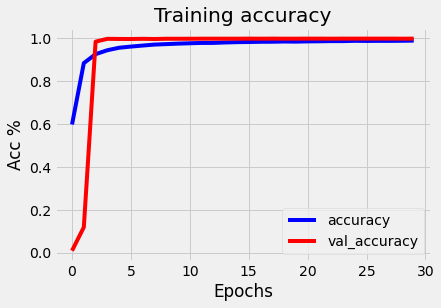

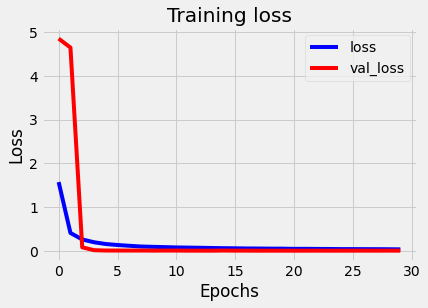

In [27]:
plot_training(history)

# Evaluating the model

In [16]:
from tensorflow.keras.models import load_model
test_model = load_model('grey-big.h5')
#test_model.summary()

In [17]:
def eval_model(true_y, pred_y):
    # model.fit(train_x, train_y)
    from sklearn import metrics
    recall_score = metrics.recall_score(y_true=true_classes, y_pred=pred_classes, average='weighted')
    print('Recall', recall_score)
    precision = metrics.precision_score(y_true=true_classes, y_pred=pred_classes, average='weighted')
    print('Precision', precision)
    f1 = metrics.f1_score(y_true=true_classes, y_pred=pred_classes, average='weighted')
    print('F1', f1)
    acc = metrics.accuracy_score(y_true=true_classes, y_pred=pred_classes)
    print('acc', acc)

In [18]:
pred = test_model.predict_classes(x_test)
true_classes = np.argmax(y_test_hot, axis=1)
pred_classes = pred
eval_model(true_classes, pred_classes)

Recall 0.9993998499624906
Precision 0.9994056502734151
F1 0.9994007065155887
acc 0.9993998499624906


# Plot matrix

In [19]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
#             42:'End no passing veh > 3.5 tons'
          }

<AxesSubplot:>

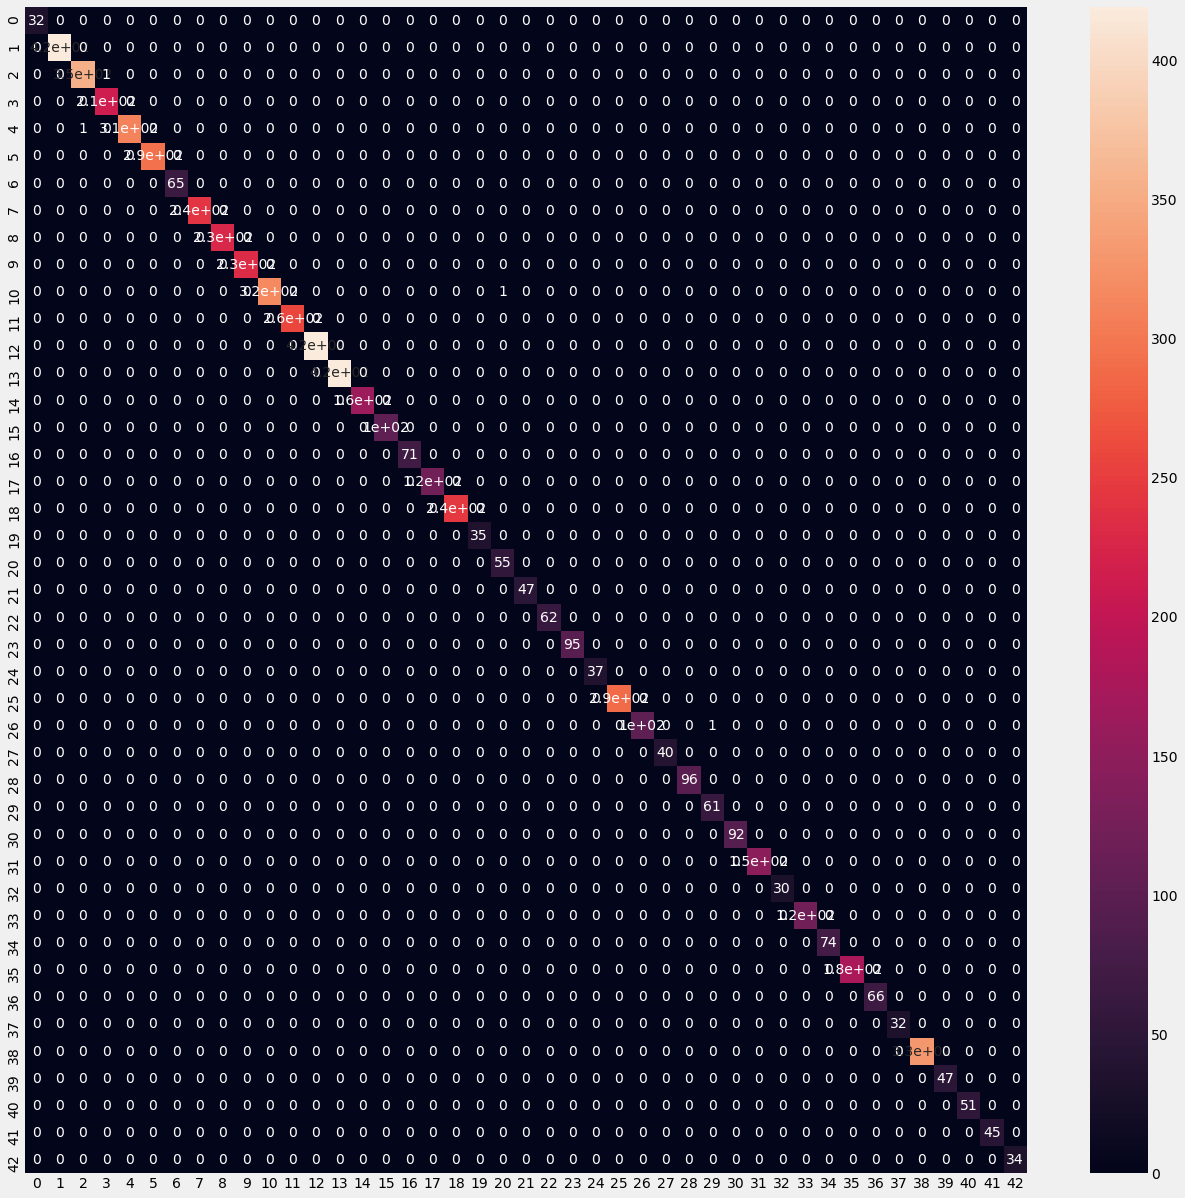

In [20]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(true_classes, pred_classes)
# print(np.unique(true_classes))
# print(np.unique(pred_classes))
# print(len(np.unique(true_classes)))
# # print(len()   
import seaborn as sns
df_cm = pd.DataFrame(cf, index = np.unique(true_classes),  columns =np.unique(pred_classes) )
# print(df_cm)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

# Classification report

In [21]:
from sklearn.metrics import classification_report

print(classification_report(true_classes, pred_classes))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      1.00      1.00       419
           2       1.00      1.00      1.00       355
           3       1.00      1.00      1.00       213
           4       1.00      1.00      1.00       311
           5       1.00      1.00      1.00       293
           6       1.00      1.00      1.00        65
           7       1.00      1.00      1.00       242
           8       1.00      1.00      1.00       226
           9       1.00      1.00      1.00       231
          10       1.00      1.00      1.00       318
          11       1.00      1.00      1.00       257
          12       1.00      1.00      1.00       418
          13       1.00      1.00      1.00       418
          14       1.00      1.00      1.00       163
          15       1.00      1.00      1.00       102
          16       1.00      1.00      1.00        71
          17       1.00    

# Predictions on Test Data

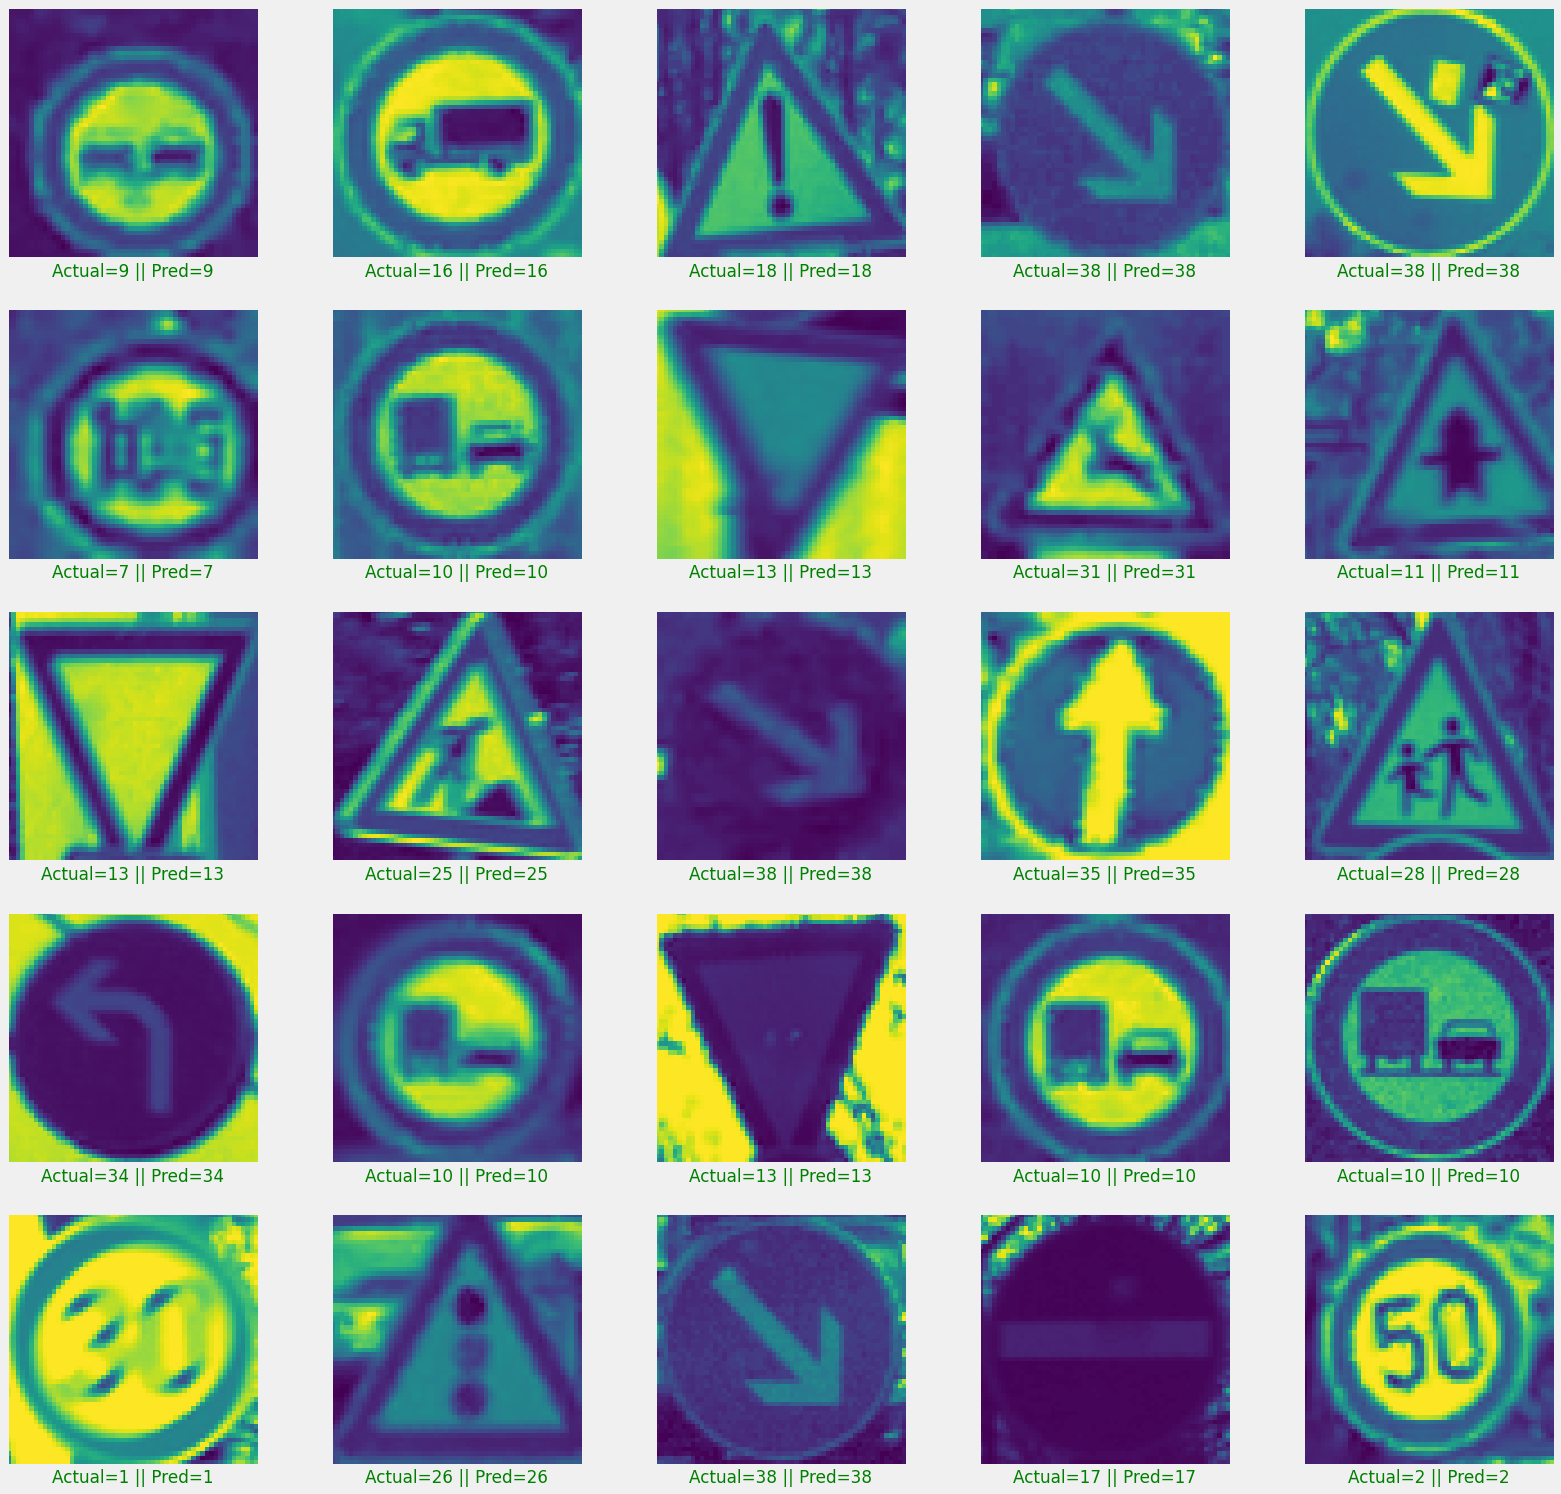

In [22]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = true_classes[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(x_test[start_index + i])
plt.show()